In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
import pathlib
pathlib.os.chdir('drive/MyDrive/rl_jungle_scenario/')

In [4]:
!ls

agent.py  jenv.py  jungle.ipynb  jungle.py  __pycache__


In [ ]:
!pip install tf-agents[reverb]

In [6]:

from agent import IMAgent
from jenv import JungleEnv

from tf_agents.utils import common
from tf_agents.environments import TFPyEnvironment
from functools import partial
from itertools import cycle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import tensorflow as tf

sns.set()


In [7]:
def print_jungle(state):
    print(state)


In [8]:
jungle_env = JungleEnv()
tf_jungle_env = TFPyEnvironment(jungle_env)


In [9]:
def jungle_action_fn(agent, action):
    return {'action': action, 'agent': agent}

In [10]:
num_iterations = 1000
initial_collect_episodes = 100
episodes_per_iteration = 10
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 3 * episodes_per_iteration * 9
learning_rate = 1e-2
plot_interval = 50
iteration = 1
games = []
loss_infos = []


In [11]:

agent_id2 = IMAgent(
    tf_jungle_env,
    action_spec=tf_jungle_env.action_spec()['action'],
    action_fn=partial(jungle_action_fn, 2),
    name='agent2', id=2, learning_rate=learning_rate,
    training_batch_size=training_batch_size,
    training_num_steps=training_num_steps,
    replay_buffer_max_length=replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)


agent_id3 = IMAgent(
    tf_jungle_env,
    action_spec=tf_jungle_env.action_spec()['action'],
    action_fn=partial(jungle_action_fn, 3),
    name='agent3', id=3, learning_rate=learning_rate,
    training_batch_size=training_batch_size,
    training_num_steps=training_num_steps,
    replay_buffer_max_length=replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)


agent_id4 = IMAgent(
    tf_jungle_env,
    action_spec=tf_jungle_env.action_spec()['action'],
    action_fn=partial(jungle_action_fn, 4),
    name='agent4', id=4, learning_rate=learning_rate,
    training_batch_size=training_batch_size,
    training_num_steps=training_num_steps,
    replay_buffer_max_length=replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)


agent_id5 = IMAgent(
    tf_jungle_env,
    action_spec=tf_jungle_env.action_spec()['action'],
    action_fn=partial(jungle_action_fn, 5),
    name='agent5', id=5, learning_rate=learning_rate,
    training_batch_size=training_batch_size,
    training_num_steps=training_num_steps,
    replay_buffer_max_length=replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)


agent_list = [agent_id2, agent_id3, agent_id4, agent_id5]


Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_1 (Dense)              multiple                  408       
Total params: 908
Trainable params: 908
Non-trainable params: 0
_________________________________________________________________
Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_5 (Dense)              multiple                  408       
Total params: 908
Trainable params: 908
Non-trainable params: 0
_________________________________________________________________
Model: "QNetwork"
__________________________

In [12]:


def training_episode(tf_jungle_env, agent_list):
    ts = tf_jungle_env.reset()
    agent_cycle = cycle(
        np.array(agent_list)[np.random.permutation(range(len(agent_list)))])
    for a in agent_list:
        a.reset()
    time_steps = []
    while not ts.is_last():
        player = next(agent_cycle)
        player.act(collect=True)
        ts = tf_jungle_env.current_time_step()
        time_steps.append(ts)
    return time_steps


In [14]:

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_jungle_env, agent_list)
print('Samples collected')


Samples collected


In [18]:

def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_jungle_env, agent_list)
        a_return_list = [a.episode_return() for a in agent_list]

        games.append({
            'iteration': iteration,
            'game': game,
            'final_step': tf_jungle_env.current_time_step(),
            'a2_return': a_return_list[0],
            'a3_return': a_return_list[1],
            'a4_return': a_return_list[2],
            'a5_return': a_return_list[3]

        })


In [19]:

def train():
    losses = []
    for _ in range(train_steps_per_iteration):
        for a in agent_list:
            losses.append(a.train_iteration().loss.numpy())

        loss_infos.append({
            'iteration': iteration,
            'agent2': losses[0],
            'agent3': losses[1],
            'agent4': losses[2],
            'agent5': losses[3]
        })


In [20]:

def plot_history(fname):

    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    for i in range(len(agent_list)):
        loss_data[f'agent{i+2}_log'] = np.log(loss_data[f"agent{i+2}"])

    fig, axs = plt.subplots(2, 1, figsize=(15, 12))

    loss_melted = pd.melt(loss_data,
                          id_vars=['iteration'],
                          value_vars=[f'agent{i + 2}_log' for i in range(len(agent_list))])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0],
                 x='iteration', hue='variable',
                 y='value', data=loss_melted)
    axs[0].set_title('Loss History')
    axs[0].set_ylabel('log-loss')

    returns_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=[f'a{i + 2}_return' for i in range(len(agent_list))])
    returns_melted.iteration = smoothing * \
        (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[1],
                 x='iteration', hue='variable',
                 y='value', data=returns_melted)
    axs[1].set_title('Return History')
    axs[1].set_ylabel('return')
    plt.savefig(fname)
    plt.show()


In [22]:
dir_name = f'lr{learning_rate:.2f}/'
pathlib.os.mkdir(dir_name)

In [23]:
dir_name

'lr0.01/'

Interrupting training, plotting history...


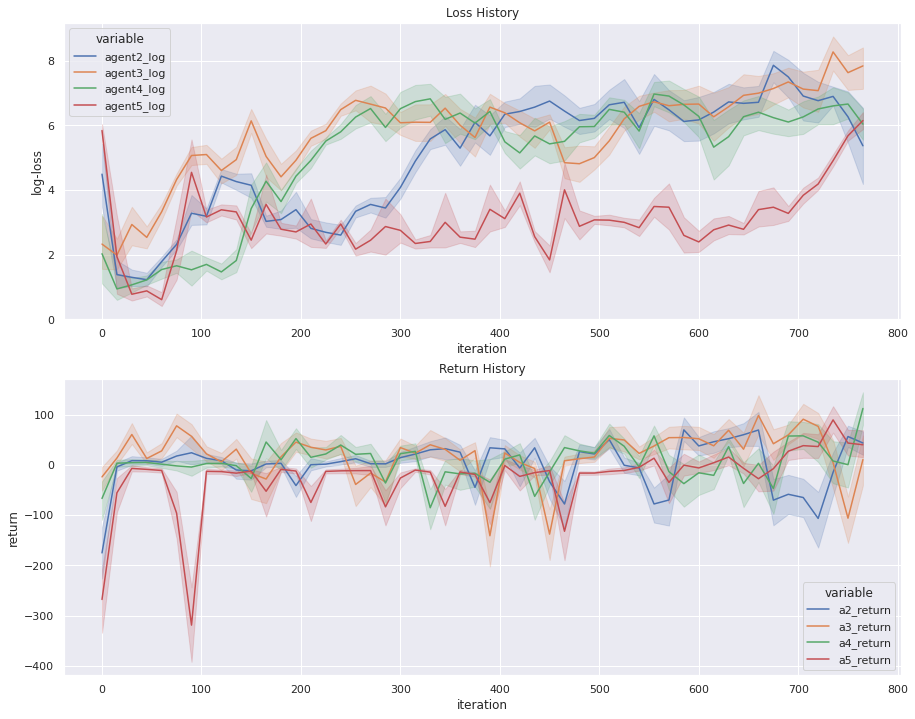

In [26]:
try:
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history(f'{dir_name}/iter{iteration}.jpg')
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history(f'{dir_name}/last_iter.jpg')

except Exception:
  print(Exception)


In [30]:
from tf_agents.policies import policy_saver
#saved the learned policies
tf_policy_saver = [policy_saver.PolicySaver(a.policy) for a in agent_list]
saved_policy_dir = pathlib.Path("saved_policies")

policy_path = [saved_policy_dir.joinpath(f"agent_{i + 2}") for i in range(len(agent_list))]
for ps, pp in zip(tf_policy_saver, policy_path):
  ps.save(str(pp))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: saved_policies/agent_2/assets


INFO:tensorflow:Assets written to: saved_policies/agent_2/assets


INFO:tensorflow:Assets written to: saved_policies/agent_3/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: saved_policies/agent_3/assets


INFO:tensorflow:Assets written to: saved_policies/agent_4/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: saved_policies/agent_4/assets


INFO:tensorflow:Assets written to: saved_policies/agent_5/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: saved_policies/agent_5/assets


In [ ]:
#reload agents to test
networks_list = [tf.saved_model.load(str(pp)) for pp in policy_path]
eval_jungle_env = JungleEnv()
tfeval_jungle_env = TFPyEnvironment(eval_jungle_env)

In [49]:

new_agent = IMAgent(
    tfeval_jungle_env,
    action_spec=tfeval_jungle_env.action_spec()['action'],
    action_fn=partial(jungle_action_fn, 2),
    name='agent2', id=2)

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_19 (Dense)             multiple                  408       
Total params: 908
Trainable params: 908
Non-trainable params: 0
_________________________________________________________________


In [51]:
tf.saved_model.save(new_agent, 'new_agentabcde')

INFO:tensorflow:Assets written to: new_agentabcde/assets


INFO:tensorflow:Assets written to: new_agentabcde/assets


In [52]:
b = tf.saved_model.load('new_agentabcde')

In [53]:
tf.saved_model.save(agent_id2, 'agent_id2')

INFO:tensorflow:Assets written to: agent_id2/assets


INFO:tensorflow:Assets written to: agent_id2/assets


In [54]:
b = tf.saved_model.load('agent_id2')

In [55]:
b

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f062e847f50>

In [60]:
model.model_variables

ListWrapper([<tf.Variable 'QNetwork/EncodingNetwork/dense/kernel:0' shape=(9, 50) dtype=float32, numpy=
array([[-4.07184273e-01, -9.74705629e-03,  4.40222830e-01,
         1.71177685e-02,  6.44928291e-02, -5.38423657e-01,
         1.05128109e-01, -7.04837799e-01, -5.60363352e-01,
        -3.41389805e-01, -2.92300545e-02, -8.85493517e-01,
        -3.49483222e-01,  9.17122185e-01, -5.96958771e-02,
        -1.91179767e-01, -6.03218079e-01, -1.91560477e-01,
         2.52751917e-01,  9.21372231e-03,  2.28594601e-01,
        -2.53286481e-01,  1.71141371e-01, -6.13071695e-02,
        -1.93313822e-01,  1.91395506e-01,  8.42305958e-01,
         5.65184653e-01,  5.33075035e-01,  1.17848612e-01,
        -4.48090702e-01, -6.73265219e-01, -3.10031295e-01,
         5.31746447e-01, -9.12564099e-02, -4.74928886e-01,
         1.37806326e-01,  5.51142871e-01, -1.01110265e-01,
         2.96717167e-01, -6.56459630e-01,  5.15139222e-01,
         4.04623419e-01, -1.54877394e-01, -4.20442909e-01,
         1.

In [64]:
ts = tfeval_jungle_env.current_time_step()

In [67]:
ts

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 20, 21), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 

In [68]:
tsa = new_agent._augment_time_step(ts)
model.action(tsa)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>, state=(), info=())

In [69]:
tfeval_jungle_env.current_time_step()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 20, 21), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 

In [71]:
new_agent.policy.action = model.action

In [73]:
new_agent.policy.action(tsa)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>, state=(), info=())

In [74]:
new_agent = IMAgent(
    tfeval_jungle_env,
    action_spec=tfeval_jungle_env.action_spec()['action'],
    action_fn=partial(jungle_action_fn, 2),
    name='agent2', id=2)

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_23 (Dense)             multiple                  408       
Total params: 908
Trainable params: 908
Non-trainable params: 0
_________________________________________________________________


In [80]:
new_agent.policy.action(tsa)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>, state=(), info=())

In [79]:
model.action(tsa)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>, state=(), info=())